In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
# Get a list of column names and types
inspector = inspect(engine)

m_columns = inspector.get_columns('measurement')
print('Measurement')
for c in m_columns:
    print(c['name'], c['type'])

s_columns = inspector.get_columns('station')
print('\nStations')
for c in s_columns:
    print(c['name'], c['type'])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
engine.execute('SELECT * FROM  Measurement LIMIT 7').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0)]

In [15]:
engine.execute('SELECT * FROM  Station LIMIT 7').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)]

# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Last date is: {last_date[0]}')

Last date is: 2017-08-23


In [17]:
# Calculate the date 1 year ago from the last data point in the database
last_year_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'The date 1 year ago is :', last_year_date)


The date 1 year ago is : 2016-08-23


In [18]:

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= last_year_date).all()

prcp_data[:7]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0)]

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.set_index('date',inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


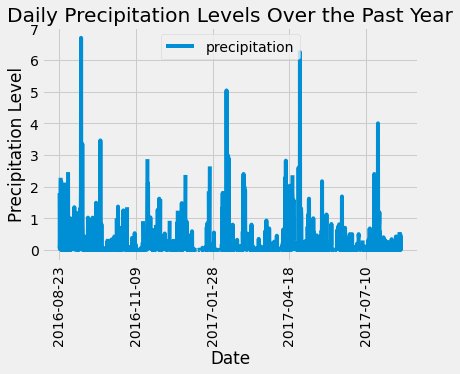

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(rot=90);
ax.set_title('Daily Precipitation Levels Over the Past Year');
ax.set_ylabel('Precipitation Level');
ax.set_xlabel('Date');

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics = prcp_df.describe()
statistics

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).group_by(Station.station).count()
print (f'Station Count =' ,station_count)

Station Count = 9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).\
desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= last_year_date).all()

USC00519281_df = pd.DataFrame(USC00519281_data)
USC00519281_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


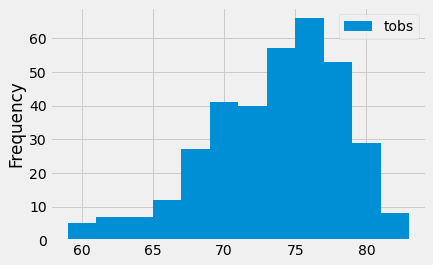

In [26]:
USC00519281_df.plot(kind='hist', bins=12)

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

temps = calc_temps(prev_year_start , prev_year_end)
temps

[(62.0, 68.36585365853658, 74.0)]

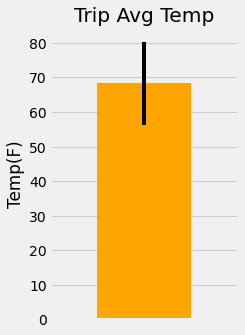

In [29]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# create the dataframe
df = pd.DataFrame(temps, columns=["t_min", "t_avg", "t_max"])

# plot the average temp 
plt.figure(figsize=(3,5))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="orange")
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()


In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query_columns = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*query_columns).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= prev_year_start).filter(Measurement.date <= prev_year_end).\
                    order_by(func.sum(Measurement.tobs).desc()).all()

stations = pd.DataFrame(last_year_data,
             columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)
stations

,Station,Station_Name,Total_Rainfall,Latitude,Longitude,Elevation
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.61,21.33556,-157.71139,19.5
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.60,21.52130,-157.83740,7.0
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.60,21.33310,-157.80250,152.4
2,USC00513117,"KANEOHE 838.1, HI US",0.35,21.42340,-157.80150,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.20,21.45167,-157.84889,32.9
4,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of thetrip_start_date = '2014-04-10'
trip_start_date = '2017-04-04'
trip_end_date = '2017-04-11'

print(f"The trip dates are {trip_start_date} to {trip_end_date}")


The trip dates are 2017-04-04 to 2017-04-11


In [39]:
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
startdate = dt.datetime.strptime(trip_start_date,'%Y-%m-%d')
enddate = dt.datetime.strptime(trip_end_date,'%Y-%m-%d') 
delta = enddate - startdate
normals = []

for i in range(delta.days + 1):
    day = startdate + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(day,'%m-%d')
    normals.append(month_day)
    
normals

['04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11']

In [40]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_list = []
for day in normals:
    normal_list.append(daily_normals(day)[0])
    
normal_list

[(58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0)]

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list,columns=["tmin","tavg","tmax"],index=[normals])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
04-04,58.0,72.016393,78.0
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <a list of 10 Text major ticklabel objects>)

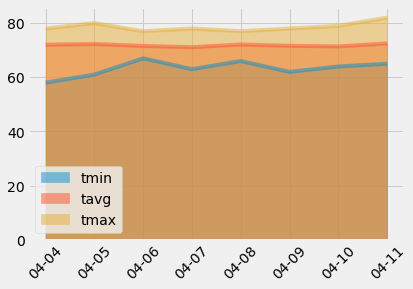

In [42]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)